# Final Project
## Name: Yu-Chen Lu
## Github Username: j12321
## USC ID: 3952152652

In [1]:
import pandas as pd
import numpy as np
import cv2
import os, os.path
import matplotlib.pyplot as plt
from scipy import ndimage
import random
import tensorflow as tf
from sklearn.metrics import classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Use path **"drive/MyDrive/Data/seg_train/"** and **"drive/MyDrive/Data/seg_test/"** on google colab; use path **"../Data/seg_train"** and **"../Data/seg_test/"** on jupyter notebook

## 1. Transfer Learning for Image Classification

It is highly recommended that you complete this project using Keras2 and Python.

### (a) In this problem, we are trying to build a classifier that distinguishes images of six scenes.

### (b) Data Exploration and Pre-processing

    i. Images in each class are given in separate folders in the training and test sets. You can encode your classes using one-hot encoding.

In [3]:
label_ls = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [4]:
df_class = pd.DataFrame({'label': label_ls, 'class': list(range(6))})
df_class

,label,class
0,buildings,0
1,forest,1
2,glacier,2
3,mountain,3
4,sea,4
5,street,5


I will encode classes using one-hot encoding during processing the data (in c ii).

    ii. In case all the images do not have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV.

I will resize the images while processing the data (in c ii).

### (c) Transfer Learning

    i. When dealing with classification of relatively small image datasets, deep net- works may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning, which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those fea- tures can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement lay- ers. In this project, you will use pre-trained models ResNet50, ResNet100, EfficientNetB0, and VGG16. For those pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.

Pre-trained models ResNet50, ResNet100, EfficientNetB0, and VGG16 in (c) iii.

    ii. To perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.

In [5]:
# Functions for image augmentation
# However, to reduce the running time, i will use the Sequential pipeline while processing data

# Crop
def crop(image):
    return cv2.resize(image[20:130, 20:130], (150, 150))

# Randomly zoom
def zoom(image):
    zoom = random.uniform(0.01, 0.2)
    h, w = image.shape[:2]
    resized = cv2.resize(image, None, fx=zoom, fy=zoom, interpolation=cv2.INTER_LINEAR)
    resized_h, resized_w = resized.shape[:2]
    if zoom >= 1:  # Zoom in (crop center)
        start_x = (resized_w - w) // 2
        start_y = (resized_h - h) // 2
        zoomed_image = resized[start_y:start_y+h, start_x:start_x+w]
    else:  # Zoom out (pad borders)
        pad_w = (w - resized_w) // 2
        pad_h = (h - resized_h) // 2
        zoomed_image = cv2.copyMakeBorder(resized, pad_h, pad_h, pad_w, pad_w, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return zoomed_image

# Rotate
def rotate(image):
    return ndimage.rotate(image, 20, reshape=False)  # rotation angel=30

# Flip
def flip(image):
    return cv2.flip(image, 1)  # set flipCode=1 to flip around the y-axis

# Contrast
def contrast(image):
    return cv2.convertScaleAbs(image, alpha=1.5, beta=0)

# Translate
def translate(image):
    height, width = image.shape[:2]
    trans_height, trans_width = height / 5, width / 5
    T = np.float32([[1, 0, trans_width], [0, 1, trans_height]])
    return cv2.warpAffine(image, T, (width, height))

In [6]:
# Data Process, including one-hot encoding, resize, image augmentation, spliting validation

# Define data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomCrop(216, 216),
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomTranslation(height_factor=0.05, width_factor=0.05)
])

# Generate dataset from image files
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='drive/MyDrive/Data/seg_train/',
    validation_split=0.2,
    subset="training",
    seed=42,
    labels='inferred',
    label_mode='categorical',
    image_size=(224, 224),
    batch_size=32,  # change batch_size from 5 to according to piazza @1156
    shuffle=True
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='drive/MyDrive/Data/seg_train/',
    validation_split=0.2,
    subset="validation",
    seed=42,
    labels='inferred',
    label_mode='categorical',
    image_size=(224, 224),
    batch_size=32,  # change batch_size from 5 to according to piazza @1156
    shuffle=False
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='drive/MyDrive/Data/seg_test/',
    labels='inferred',
    label_mode='categorical',
    image_size=(224, 224),
    batch_size=32,  # change batch_size from 5 to according to piazza @1156
    shuffle=False
)

# Apply data augmentation to training data
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))

Found 14044 files belonging to 6 classes.
Using 11236 files for training.
Found 14044 files belonging to 6 classes.
Using 2808 files for validation.
Found 3000 files belonging to 6 classes.


    iii. Use ReLU activation functions in the last layer and a softmax layer, along with 2 regularization, batch normalization 4, and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable.

In [7]:
num_class = 6
dropout_rate = 0.2

**ResNet50**

In [8]:
# base model: ResNet50
base_resnet50 = tf.keras.applications.ResNet50(weights='imagenet',include_top=False,input_shape=(224, 224, 3))  # include_top=False allows feature extraction by removing the last dense layers

# freeze layers
base_resnet50.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_resnet50(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
output = tf.keras.layers.Dense(num_class, activation='softmax')(x)
resnet50 = tf.keras.models.Model(inputs, output)
resnet50.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,648,070 (94.02 MB)

 Trainable params: 1,056,262 (4.03 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

**ResNet100**

In [9]:
# base model: ResNet101
base_resnet101 = tf.keras.applications.ResNet101(weights='imagenet',include_top=False,input_shape=(224, 224, 3))  # include_top=False allows feature extraction by removing the last dense layers

# freeze layers
base_resnet101.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_resnet101(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
output = tf.keras.layers.Dense(num_class, activation='softmax')(x)
resnet101 = tf.keras.models.Model(inputs, output)
resnet101.summary()

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet101 (Functional)               │ (None, 7, 7, 2048)          │      42,658,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,718,534 (166.77 MB)

 Trainable params: 1,056,262 (4.03 MB)

 Non-trainable params: 42,662,272 (162.74 MB)

**EfficientNetB0**

In [10]:
# base model: EfficientNetB0
base_efficientnetb0 = tf.keras.applications.EfficientNetB0(weights='imagenet',include_top=False,input_shape=(224, 224, 3))  # include_top=False allows feature extraction by removing the last dense layers

# freeze layers
base_efficientnetb0.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_efficientnetb0(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
output = tf.keras.layers.Dense(num_class, activation='softmax')(x)
efficientnetb0 = tf.keras.models.Model(inputs, output)
efficientnetb0.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,713,641 (17.98 MB)

 Trainable params: 661,510 (2.52 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

**VGG16**

In [11]:
# base model: VGG16
base_vgg16 = tf.keras.applications.VGG16(weights='imagenet',include_top=False,input_shape=(224, 224, 3))  # include_top=False allows feature extraction by removing the last dense layers

# freeze layers
base_vgg16.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_vgg16(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
output = tf.keras.layers.Dense(num_class, activation='softmax')(x)
vgg16 = tf.keras.models.Model(inputs, output)
vgg16.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,982,470 (57.15 MB)

 Trainable params: 266,758 (1.02 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

    iv. Train the networks for at least 50 epochs (preferably 100 epochs) and perform early stopping using the validation set. Use a randomly selected subset of 20% of each class as the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

In [ ]:
# use GPU (codes refer to piazza @1158)
'''
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
'''

"\ngpus = tf.config.experimental.list_physical_devices('GPU')\nfor gpu in gpus:\n  tf.config.experimental.set_memory_growth(gpu, True)\n"

**ResNet50**

In [ ]:
base_resnet50 = tf.keras.applications.ResNet50(weights='imagenet',include_top=False,input_shape=(224, 224, 3))
base_resnet50.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_resnet50(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
output = tf.keras.layers.Dense(num_class, activation='softmax')(x)
resnet50 = tf.keras.models.Model(inputs, output)
resnet50.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')]
)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('resnet50.keras', monitor='val_loss', save_best_only=True)

# Train the model
resnet50_history = resnet50.fit(
    train_dataset,
    batch_size=32,  # change batch_size from 5 to according to piazza @1156
    epochs=50,
    validation_data=validation_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 227s 607ms/step - accuracy: 0.7655 - auc: 0.9446 - loss: 1.6590 - precision: 0.7808 - recall: 0.7524 - val_accuracy: 0.8202 - val_auc: 0.9732 - val_loss: 1.2752 - val_precision: 0.8241 - val_recall: 0.8173
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 189s 535ms/step - accuracy: 0.8396 - auc: 0.9780 - loss: 1.1543 - precision: 0.8473 - recall: 0.8314 - val_accuracy: 0.9199 - val_auc: 0.9937 - val_loss: 0.7961 - val_precision: 0.9208 - val_recall: 0.9195
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 189s 536ms/step - accuracy: 0.8653 - auc: 0.9836 - loss: 0.9271 - precision: 0.8776 - recall: 0.8545 - val_accuracy: 0.9551 - val_auc: 0.9978 - val_loss: 0.5798 - val_precision: 0.9582 - val_recall: 0.9541
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 188s 533ms/step - accuracy: 0.8653 - auc: 0.9843 - loss: 0.8092 - precision: 0.8754 - recall: 0.8533 - val_accuracy: 0.9145 - val_auc: 0.9927 - val_loss: 0.6095 - val_precision: 0.9164 - val_recall: 0.9099
Epoch 5/50
352/3

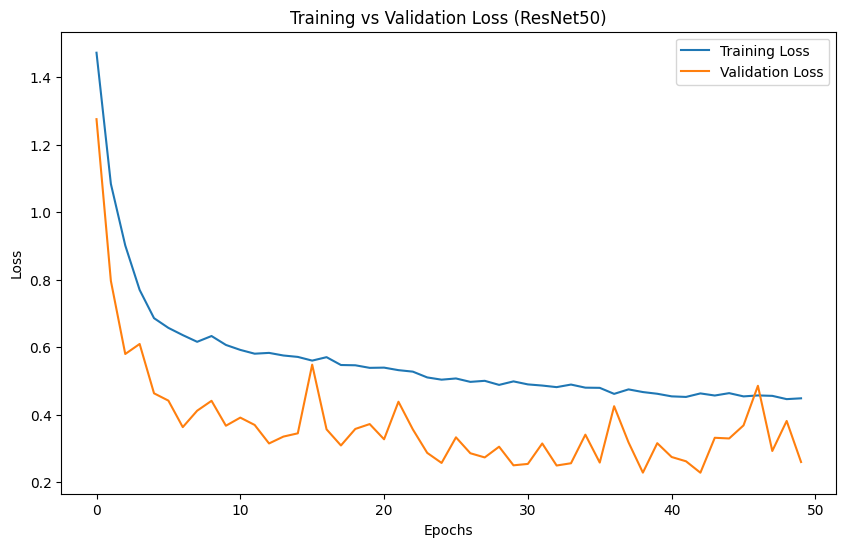

In [ ]:
# Plot training and validation errors vs. epochs
plt.figure(figsize=(10, 6))
plt.plot(resnet50_history.history['loss'], label='Training Loss')
plt.plot(resnet50_history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss (ResNet50)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**ResNet100**

In [ ]:
base_resnet101 = tf.keras.applications.ResNet101(weights='imagenet',include_top=False,input_shape=(224, 224, 3))
base_resnet101.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_resnet101(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
output = tf.keras.layers.Dense(num_class, activation='softmax')(x)
resnet101 = tf.keras.models.Model(inputs, output)
resnet101.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')]
)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('resnet101.keras', monitor='val_loss', save_best_only=True)

# Train the model
resnet101_history = resnet101.fit(
    train_dataset,
    batch_size=32,  # change batch_size from 5 to according to piazza @1156
    epochs=50,
    validation_data=validation_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 222s 579ms/step - accuracy: 0.7666 - auc: 0.9466 - loss: 1.6523 - precision: 0.7822 - recall: 0.7546 - val_accuracy: 0.9683 - val_auc: 0.9974 - val_loss: 0.8543 - val_precision: 0.9713 - val_recall: 0.9644
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 189s 536ms/step - accuracy: 0.8438 - auc: 0.9781 - loss: 1.1706 - precision: 0.8548 - recall: 0.8356 - val_accuracy: 0.9712 - val_auc: 0.9982 - val_loss: 0.6862 - val_precision: 0.9728 - val_recall: 0.9690
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 189s 537ms/step - accuracy: 0.8651 - auc: 0.9833 - loss: 0.9348 - precision: 0.8768 - recall: 0.8541 - val_accuracy: 0.9291 - val_auc: 0.9943 - val_loss: 0.6513 - val_precision: 0.9313 - val_recall: 0.9274
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 189s 537ms/step - accuracy: 0.8686 - auc: 0.9841 - loss: 0.8014 - precision: 0.8803 - recall: 0.8567 - val_accuracy: 0.9875 - val_auc: 0.9992 - val_loss: 0.4235 - val_precision: 0.9900 - val_recall: 0.9847
Epoch 5/50
352/3

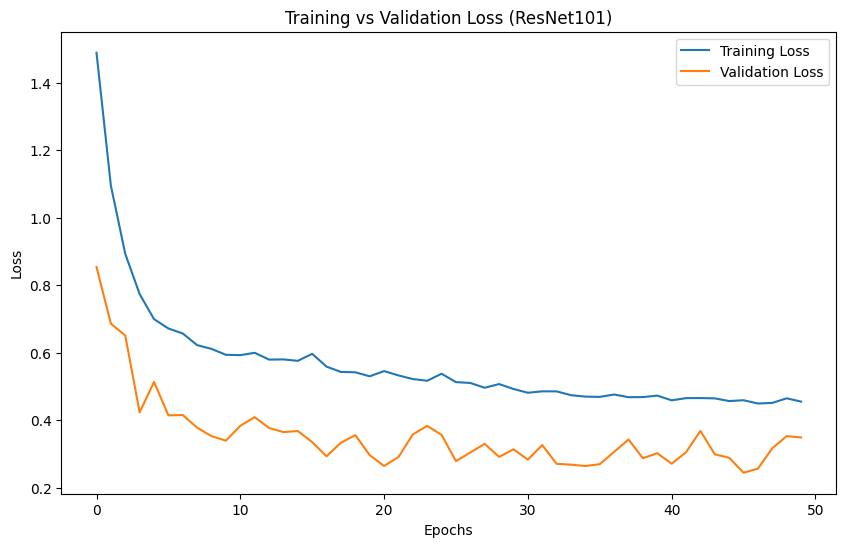

In [ ]:
# Plot training and validation errors vs. epochs
plt.figure(figsize=(10, 6))
plt.plot(resnet101_history.history['loss'], label='Training Loss')
plt.plot(resnet101_history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss (ResNet101)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**EfficientNetB0**

In [12]:
base_efficientnetb0 = tf.keras.applications.EfficientNetB0(weights='imagenet',include_top=False,input_shape=(224, 224, 3))
base_efficientnetb0.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_efficientnetb0(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
output = tf.keras.layers.Dense(num_class, activation='softmax')(x)
efficientnetb0 = tf.keras.models.Model(inputs, output)
efficientnetb0.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')]
)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('efficientnetb0.keras', monitor='val_loss', save_best_only=True)

# Train the model
efficientnetb0_history = efficientnetb0.fit(
    train_dataset,
    batch_size=32,  # change batch_size from 5 to according to piazza @1156
    epochs=50,
    validation_data=validation_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 296s 767ms/step - accuracy: 0.7591 - auc: 0.9482 - loss: 1.4781 - precision: 0.7769 - recall: 0.7424 - val_accuracy: 0.9395 - val_auc: 0.9973 - val_loss: 0.7791 - val_precision: 0.9404 - val_recall: 0.9380
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 188s 533ms/step - accuracy: 0.8387 - auc: 0.9792 - loss: 1.0394 - precision: 0.8475 - recall: 0.8284 - val_accuracy: 0.9886 - val_auc: 0.9999 - val_loss: 0.5192 - val_precision: 0.9900 - val_recall: 0.9872
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 188s 533ms/step - accuracy: 0.8575 - auc: 0.9826 - loss: 0.8487 - precision: 0.8667 - recall: 0.8479 - val_accuracy: 0.9801 - val_auc: 0.9996 - val_loss: 0.4287 - val_precision: 0.9811 - val_recall: 0.9786
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 188s 534ms/step - accuracy: 0.8604 - auc: 0.9846 - loss: 0.7304 - precision: 0.8745 - recall: 0.8503 - val_accuracy: 0.9544 - val_auc: 0.9982 - val_loss: 0.4215 - val_precision: 0.9544 - val_recall: 0.9530
Epoch 5/50
352/3

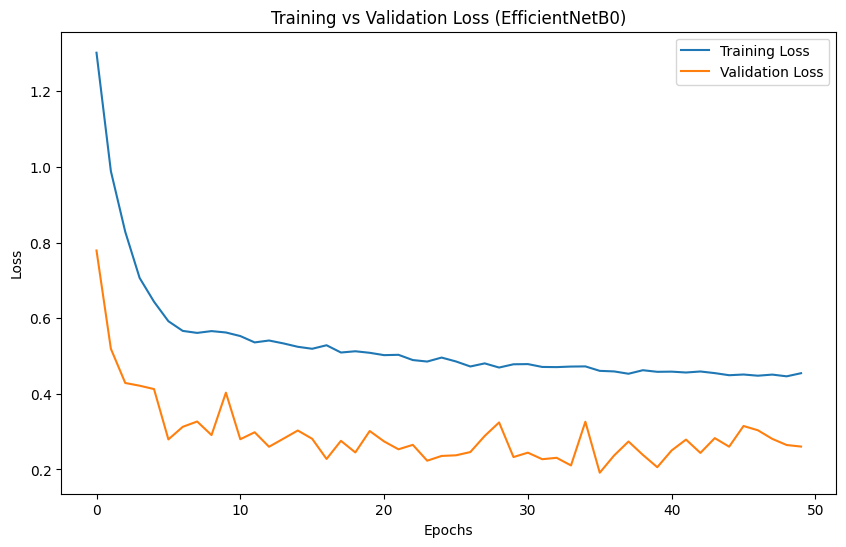

In [13]:
# Plot training and validation errors vs. epochs
plt.figure(figsize=(10, 6))
plt.plot(efficientnetb0_history.history['loss'], label='Training Loss')
plt.plot(efficientnetb0_history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss (EfficientNetB0)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**VGG16**

In [22]:
base_vgg16 = tf.keras.applications.VGG16(weights='imagenet',include_top=False,input_shape=(224, 224, 3))
base_vgg16.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_vgg16(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
output = tf.keras.layers.Dense(num_class, activation='softmax')(x)
vgg16 = tf.keras.models.Model(inputs, output)
vgg16.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')]
)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('vgg16.keras', monitor='val_loss', save_best_only=True)

# Train the model
vgg16_history = vgg16.fit(
    train_dataset,
    batch_size=32,  # change batch_size from 5 to according to piazza @1156
    epochs=50,
    validation_data=validation_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 202s 555ms/step - accuracy: 0.7132 - auc: 0.9374 - loss: 1.2770 - precision: 0.7504 - recall: 0.6749 - val_accuracy: 0.9491 - val_auc: 0.9966 - val_loss: 0.5817 - val_precision: 0.9536 - val_recall: 0.9448
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 189s 536ms/step - accuracy: 0.8116 - auc: 0.9732 - loss: 0.9059 - precision: 0.8321 - recall: 0.7934 - val_accuracy: 0.9363 - val_auc: 0.9963 - val_loss: 0.5076 - val_precision: 0.9409 - val_recall: 0.9348
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 189s 536ms/step - accuracy: 0.8246 - auc: 0.9775 - loss: 0.7762 - precision: 0.8425 - recall: 0.8018 - val_accuracy: 0.9590 - val_auc: 0.9982 - val_loss: 0.3848 - val_precision: 0.9631 - val_recall: 0.9583
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 189s 536ms/step - accuracy: 0.8212 - auc: 0.9773 - loss: 0.7139 - precision: 0.8407 - recall: 0.8026 - val_accuracy: 0.9576 - val_auc: 0.9980 - val_loss: 0.3465 - val_precision: 0.9609 - val_recall: 0.9548
Epoch 5/50
352/3

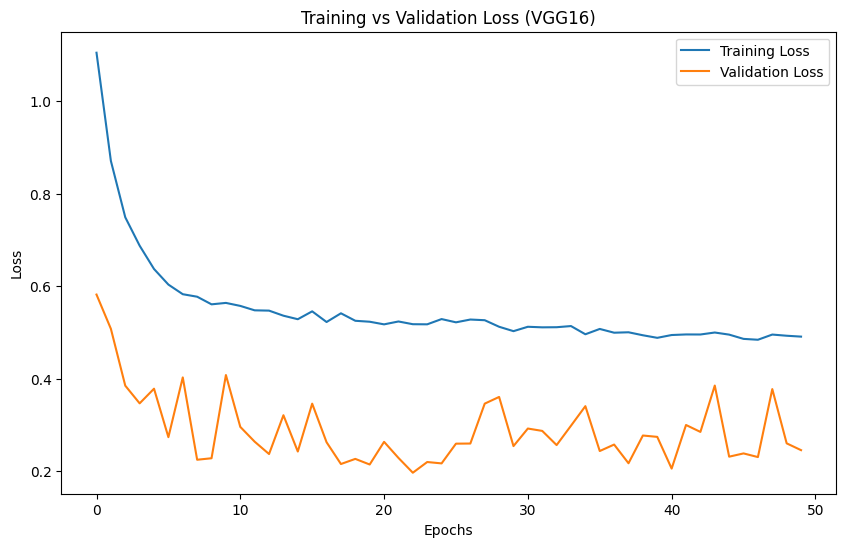

In [23]:
# Plot training and validation errors vs. epochs
plt.figure(figsize=(10, 6))
plt.plot(vgg16_history.history['loss'], label='Training Loss')
plt.plot(vgg16_history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss (VGG16)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

    v. Report training, validation, and test Precision, Recall, AUC, and F1 score for those models. Is there a model that clearly outperforms others? Remember that this is a multi-class classification problem.

In [16]:
def f1score(precision, recall):
    f1 = 2 * ((precision * recall) / (precision + recall))
    return f1

In [17]:
x_test = np.concatenate([x.numpy() for x, y in test_dataset], axis=0)
y_test = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)

**ResNet50**

In [ ]:
# Evaluate on the test set
resnet50_test_results = resnet50.evaluate(test_dataset, return_dict=True)

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8817 - auc: 0.9825 - loss: 0.5286 - precision: 0.8865 - recall: 0.8771


In [ ]:
# result for training
resnet50_train_precision = resnet50_history.history['precision']
resnet50_train_recall = resnet50_history.history['recall']
resnet50_train_auc = resnet50_history.history['auc']
resnet50_train_f1 = []
for i in range(len(resnet50_train_precision)):
    f1 = f1score(resnet50_train_precision[i], resnet50_train_recall[i])
    resnet50_train_f1.append(f1)
resnet50_train_df = pd.DataFrame({'Precision': [min(resnet50_train_precision), max(resnet50_train_precision), np.mean(resnet50_train_precision)],
                                  'Recall': [min(resnet50_train_recall), max(resnet50_train_recall), np.mean(resnet50_train_recall)],
                                  'AUC': [min(resnet50_train_auc), max(resnet50_train_auc), np.mean(resnet50_train_auc)],
                                  'F1 Score': [min(resnet50_train_f1), max(resnet50_train_f1), np.mean(resnet50_train_f1)]},
                                  index=(['Min', 'Max', 'Mean']))
resnet50_train_df

,Precision,Recall,AUC,F1 Score
Min,0.820618,0.801264,0.961774,0.810825
Max,0.904879,0.883054,0.990153,0.893834
Mean,0.891793,0.868565,0.987547,0.880025


In [ ]:
# result for validation
resnet50_val_precision = resnet50_history.history['val_precision']
resnet50_val_recall = resnet50_history.history['val_recall']
resnet50_val_auc = resnet50_history.history['val_auc']
resnet50_val_f1 = []
for i in range(len(resnet50_val_precision)):
    f1 = f1score(resnet50_val_precision[i], resnet50_val_recall[i])
    resnet50_val_f1.append(f1)
resnet50_val_df = pd.DataFrame({'Precision': [min(resnet50_val_precision), max(resnet50_val_precision), np.mean(resnet50_val_precision)],
                                  'Recall': [min(resnet50_val_recall), max(resnet50_val_recall), np.mean(resnet50_val_recall)],
                                  'AUC': [min(resnet50_val_auc), max(resnet50_val_auc), np.mean(resnet50_val_auc)],
                                  'F1 Score': [min(resnet50_val_f1), max(resnet50_val_f1), np.mean(resnet50_val_f1)]},
                                  index=(['Min', 'Max', 'Mean']))
resnet50_val_df

,Precision,Recall,AUC,F1 Score
Min,0.824057,0.817308,0.973179,0.820669
Max,0.983963,0.983262,0.999439,0.983612
Mean,0.947959,0.944031,0.996493,0.945990


In [ ]:
# result for test
print(f"Test Precision: {resnet50_test_results['precision']}")
print(f"Test Recall: {resnet50_test_results['recall']}")
print(f"Test AUC: {resnet50_test_results['auc']}")
print(f"Test Precision: {f1score(resnet50_test_results['precision'], resnet50_test_results['recall'])}")
# Sorry there is a typo here, the last line should be Test f1 score

Test Precision: 0.9040540456771851
Test Recall: 0.8920000195503235
Test AUC: 0.9869876503944397
Test Precision: 0.8979865829556175


In [ ]:
y_pred_class = np.argmax(resnet50.predict(x_test), axis=-1)
y_test_class = np.argmax(y_test, axis=1)

print(classification_report(y_test_class, y_pred_class))

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
              precision    recall  f1-score   support

           0       0.94      0.86      0.90       437
           1       0.98      0.98      0.98       474
           2       0.87      0.82      0.85       553
           3       0.87      0.80      0.83       525
           4       0.86      0.96      0.91       510
           5       0.88      0.97      0.92       501

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000



**ResNet100**

In [ ]:
# Evaluate on the test set
resnet101_test_results = resnet101.evaluate(test_dataset, return_dict=True)

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.8887 - auc: 0.9879 - loss: 0.4847 - precision: 0.8931 - recall: 0.8869


In [ ]:
# result for training
resnet101_train_precision = resnet101_history.history['precision']
resnet101_train_recall = resnet101_history.history['recall']
resnet101_train_auc = resnet101_history.history['auc']
resnet101_train_f1 = []
for i in range(len(resnet101_train_precision)):
    f1 = f1score(resnet101_train_precision[i], resnet101_train_recall[i])
    resnet101_train_f1.append(f1)
resnet101_train_df = pd.DataFrame({'Precision': [min(resnet101_train_precision), max(resnet101_train_precision), np.mean(resnet101_train_precision)],
                                  'Recall': [min(resnet101_train_recall), max(resnet101_train_recall), np.mean(resnet101_train_recall)],
                                  'AUC': [min(resnet101_train_auc), max(resnet101_train_auc), np.mean(resnet101_train_auc)],
                                  'F1 Score': [min(resnet101_train_f1), max(resnet101_train_f1), np.mean(resnet101_train_f1)]},
                                  index=(['Min', 'Max', 'Mean']))
resnet101_train_df

,Precision,Recall,AUC,F1 Score
Min,0.816211,0.797615,0.962291,0.806806
Max,0.902045,0.879672,0.989947,0.890581
Mean,0.890871,0.867398,0.987387,0.878977


In [ ]:
# result for validation
resnet101_val_precision = resnet101_history.history['val_precision']
resnet101_val_recall = resnet101_history.history['val_recall']
resnet101_val_auc = resnet101_history.history['val_auc']
resnet101_val_f1 = []
for i in range(len(resnet101_val_precision)):
    f1 = f1score(resnet101_val_precision[i], resnet101_val_recall[i])
    resnet101_val_f1.append(f1)
resnet101_val_df = pd.DataFrame({'Precision': [min(resnet101_val_precision), max(resnet101_val_precision), np.mean(resnet101_val_precision)],
                                  'Recall': [min(resnet101_val_recall), max(resnet101_val_recall), np.mean(resnet101_val_recall)],
                                  'AUC': [min(resnet101_val_auc), max(resnet101_val_auc), np.mean(resnet101_val_auc)],
                                  'F1 Score': [min(resnet101_val_f1), max(resnet101_val_f1), np.mean(resnet101_val_f1)]},
                                  index=(['Min', 'Max', 'Mean']))
resnet101_val_df

,Precision,Recall,AUC,F1 Score
Min,0.924847,0.915954,0.994263,0.920379
Max,0.989975,0.984687,0.999544,0.987324
Mean,0.957484,0.952244,0.997775,0.954856


In [ ]:
# result for test
print(f"Test Precision: {resnet101_test_results['precision']}")
print(f"Test Recall: {resnet101_test_results['recall']}")
print(f"Test AUC: {resnet101_test_results['auc']}")
print(f"Test Precision: {f1score(resnet101_test_results['precision'], resnet101_test_results['recall'])}")
# Sorry there is a typo here, the last line should be Test f1 score

Test Precision: 0.9017496705055237
Test Recall: 0.8933333158493042
Test AUC: 0.9899581670761108
Test Precision: 0.8975217628846538


In [ ]:
y_pred_class = np.argmax(resnet101.predict(x_test), axis=-1)
y_test_class = np.argmax(y_test, axis=1)

print(classification_report(y_test_class, y_pred_class))

94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       437
           1       0.99      0.98      0.98       474
           2       0.88      0.83      0.86       553
           3       0.87      0.81      0.84       525
           4       0.86      0.96      0.91       510
           5       0.88      0.94      0.91       501

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000



**EfficientNetB0**

In [14]:
# Evaluate on the test set
efficientnetb0_test_results = efficientnetb0.evaluate(test_dataset, return_dict=True)

94/94 ━━━━━━━━━━━━━━━━━━━━ 49s 523ms/step - accuracy: 0.8781 - auc: 0.9877 - loss: 0.4680 - precision: 0.8813 - recall: 0.8748


In [18]:
# result for training
efficientnetb0_train_precision = efficientnetb0_history.history['precision']
efficientnetb0_train_recall = efficientnetb0_history.history['recall']
efficientnetb0_train_auc = efficientnetb0_history.history['auc']
efficientnetb0_train_f1 = []
for i in range(len(efficientnetb0_train_precision)):
    f1 = f1score(efficientnetb0_train_precision[i], efficientnetb0_train_recall[i])
    efficientnetb0_train_f1.append(f1)
efficientnetb0_train_df = pd.DataFrame({'Precision': [min(efficientnetb0_train_precision), max(efficientnetb0_train_precision), np.mean(efficientnetb0_train_precision)],
                                  'Recall': [min(efficientnetb0_train_recall), max(efficientnetb0_train_recall), np.mean(efficientnetb0_train_recall)],
                                  'AUC': [min(efficientnetb0_train_auc), max(efficientnetb0_train_auc), np.mean(efficientnetb0_train_auc)],
                                  'F1 Score': [min(efficientnetb0_train_f1), max(efficientnetb0_train_f1), np.mean(efficientnetb0_train_f1)]},
                                  index=(['Min', 'Max', 'Mean']))
efficientnetb0_train_df

,Precision,Recall,AUC,F1 Score
Min,0.816375,0.793343,0.966165,0.804694
Max,0.894444,0.874066,0.988712,0.884138
Mean,0.883113,0.860116,0.986679,0.871462


In [19]:
# result for validation
efficientnetb0_val_precision = efficientnetb0_history.history['val_precision']
efficientnetb0_val_recall = efficientnetb0_history.history['val_recall']
efficientnetb0_val_auc = efficientnetb0_history.history['val_auc']
efficientnetb0_val_f1 = []
for i in range(len(efficientnetb0_val_precision)):
    f1 = f1score(efficientnetb0_val_precision[i], efficientnetb0_val_recall[i])
    efficientnetb0_val_f1.append(f1)
efficientnetb0_val_df = pd.DataFrame({'Precision': [min(efficientnetb0_val_precision), max(efficientnetb0_val_precision), np.mean(efficientnetb0_val_precision)],
                                  'Recall': [min(efficientnetb0_val_recall), max(efficientnetb0_val_recall), np.mean(efficientnetb0_val_recall)],
                                  'AUC': [min(efficientnetb0_val_auc), max(efficientnetb0_val_auc), np.mean(efficientnetb0_val_auc)],
                                  'F1 Score': [min(efficientnetb0_val_f1), max(efficientnetb0_val_f1), np.mean(efficientnetb0_val_f1)]},
                                  index=(['Min', 'Max', 'Mean']))
efficientnetb0_val_df

,Precision,Recall,AUC,F1 Score
Min,0.920300,0.917023,0.995154,0.918659
Max,0.990000,0.987179,0.999934,0.988588
Mean,0.962067,0.959679,0.998443,0.960872


In [29]:
# result for test
print(f"Test Precision: {efficientnetb0_test_results['precision']}")
print(f"Test Recall: {efficientnetb0_test_results['recall']}")
print(f"Test AUC: {efficientnetb0_test_results['auc']}")
print(f"Test F1 score: {f1score(efficientnetb0_test_results['precision'], efficientnetb0_test_results['recall'])}")

Test Precision: 0.9125756621360779
Test Recall: 0.9046666622161865
Test AUC: 0.991856038570404
Test F1 score: 0.9086039514060289


In [21]:
y_pred_class = np.argmax(efficientnetb0.predict(x_test), axis=-1)
y_test_class = np.argmax(y_test, axis=1)

print(classification_report(y_test_class, y_pred_class))

94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step
              precision    recall  f1-score   support

           0       0.96      0.82      0.89       437
           1       1.00      0.99      0.99       474
           2       0.87      0.83      0.85       553
           3       0.87      0.86      0.86       525
           4       0.92      0.98      0.95       510
           5       0.86      0.97      0.91       501

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



**VGG16**

In [24]:
# Evaluate on the test set
vgg16_test_results = vgg16.evaluate(test_dataset, return_dict=True)

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.8274 - auc: 0.9738 - loss: 0.6191 - precision: 0.8348 - recall: 0.8220


In [25]:
# result for training
vgg16_train_precision = vgg16_history.history['precision']
vgg16_train_recall = vgg16_history.history['recall']
vgg16_train_auc = vgg16_history.history['auc']
vgg16_train_f1 = []
for i in range(len(vgg16_train_precision)):
    f1 = f1score(vgg16_train_precision[i], vgg16_train_recall[i])
    vgg16_train_f1.append(f1)
vgg16_train_df = pd.DataFrame({'Precision': [min(vgg16_train_precision), max(vgg16_train_precision), np.mean(vgg16_train_precision)],
                                  'Recall': [min(vgg16_train_recall), max(vgg16_train_recall), np.mean(vgg16_train_recall)],
                                  'AUC': [min(vgg16_train_auc), max(vgg16_train_auc), np.mean(vgg16_train_auc)],
                                  'F1 Score': [min(vgg16_train_f1), max(vgg16_train_f1), np.mean(vgg16_train_f1)]},
                                  index=(['Min', 'Max', 'Mean']))
vgg16_train_df

,Precision,Recall,AUC,F1 Score
Min,0.796384,0.744927,0.961069,0.769797
Max,0.880030,0.843628,0.985279,0.861026
Mean,0.866397,0.830153,0.982444,0.847884


In [26]:
# result for validation
vgg16_val_precision = vgg16_history.history['val_precision']
vgg16_val_recall = vgg16_history.history['val_recall']
vgg16_val_auc = vgg16_history.history['val_auc']
vgg16_val_f1 = []
for i in range(len(vgg16_val_precision)):
    f1 = f1score(vgg16_val_precision[i], vgg16_val_recall[i])
    vgg16_val_f1.append(f1)
vgg16_val_df = pd.DataFrame({'Precision': [min(vgg16_val_precision), max(vgg16_val_precision), np.mean(vgg16_val_precision)],
                                  'Recall': [min(vgg16_val_recall), max(vgg16_val_recall), np.mean(vgg16_val_recall)],
                                  'AUC': [min(vgg16_val_auc), max(vgg16_val_auc), np.mean(vgg16_val_auc)],
                                  'F1 Score': [min(vgg16_val_f1), max(vgg16_val_f1), np.mean(vgg16_val_f1)]},
                                  index=(['Min', 'Max', 'Mean']))
vgg16_val_df

,Precision,Recall,AUC,F1 Score
Min,0.899175,0.892450,0.991179,0.895800
Max,0.984588,0.978276,0.999276,0.981422
Mean,0.953469,0.947350,0.997163,0.950399


In [30]:
# result for test
print(f"Test Precision: {vgg16_test_results['precision']}")
print(f"Test Recall: {vgg16_test_results['recall']}")
print(f"Test AUC: {vgg16_test_results['auc']}")
print(f"Test F1 Score: {f1score(vgg16_test_results['precision'], vgg16_test_results['recall'])}")

Test Precision: 0.8812351822853088
Test Recall: 0.8656666874885559
Test AUC: 0.9846795201301575
Test F1 Score: 0.8733815612047495


In [28]:
y_pred_class = np.argmax(vgg16.predict(x_test), axis=-1)
y_test_class = np.argmax(y_test, axis=1)

print(classification_report(y_test_class, y_pred_class))

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
              precision    recall  f1-score   support

           0       0.97      0.74      0.84       437
           1       0.98      0.99      0.98       474
           2       0.81      0.83      0.82       553
           3       0.86      0.76      0.81       525
           4       0.87      0.95      0.91       510
           5       0.80      0.98      0.88       501

    accuracy                           0.87      3000
   macro avg       0.88      0.87      0.87      3000
weighted avg       0.88      0.87      0.87      3000



According to the results of four models, all models have good performance. However, according to the test classification report, there isn't a model that clearly outperform other models when classifying all 6 classes.

## Reference

Rotate image https://stackoverflow.com/questions/37119071/scipy-rotate-and-zoom-an-image-without-changing-its-dimensions

Zoom image https://stackoverflow.com/questions/69050464/zoom-into-image-with-opencv

Flip image https://www.tutorialspoint.com/how-to-flip-an-image-in-opencv-python

Contrast image https://stackoverflow.com/questions/39308030/how-do-i-increase-the-contrast-of-an-image-in-python-opencv

Translate image https://www.geeksforgeeks.org/image-translation-using-opencv-python/

Data Augmentation with keras pipeline https://www.tensorflow.org/tutorials/images/data_augmentation

Generate dataset from image files https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

Transfer Learning https://keras.io/guides/transfer_learning/

Keras Regularization https://keras.io/api/layers/regularizers/

Train and test models with keras https://keras.io/api/models/model_training_apis/

Precision, Recall, AUC https://www.tensorflow.org/api_docs/python/tf/keras/Model

Callback History https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

